# 02 - Entrenamiento del Transformer

Este notebook ejecuta el pipeline completo de entrenamiento:
1. Cargar y tokenizar datos
2. Instanciar el modelo Transformer
3. Entrenar con custom training loop
4. Guardar modelo y visualizar curvas

In [2]:
import os
import sys
import json
import numpy as np
import tensorflow as tf

# Agregar directorio raíz al path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Agregar directorio padre para imports del paquete
parent_dir = os.path.dirname(project_root)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")
print(f"Directorio del proyecto: {project_root}")

TensorFlow version: 2.20.0
GPU disponible: []
Directorio del proyecto: /home/melissa/transformer_math_physics_tutor


## 1. Importar Módulos del Proyecto

In [3]:
from transformer_math_physics_tutor.data.tokenizer import CharTokenizer
from transformer_math_physics_tutor.data.dataset_builder import create_dataset, create_train_val_datasets
from transformer_math_physics_tutor.models.config import TransformerConfig
from transformer_math_physics_tutor.models.transformer import Transformer
from transformer_math_physics_tutor.training.train import TransformerTrainer
from transformer_math_physics_tutor.training.scheduler import CustomSchedule

print("Todos los módulos importados correctamente.")

Todos los módulos importados correctamente.


## 2. Cargar Datos y Crear Tokenizer

In [ ]:
# Determinar qué dataset usar
data_dir = os.path.join(project_root, 'data')
math_data_path = os.path.join(data_dir, 'math_clean.json')
physics_path = os.path.join(data_dir, 'physics_problems.json')

# Usar math_clean si existe, sino usar physics_problems
if os.path.exists(math_data_path):
    data_file = math_data_path
    print(f"Usando dataset MATH: {data_file}")
elif os.path.exists(physics_path):
    data_file = physics_path
    print(f"Usando dataset de Física: {data_file}")
else:
    raise FileNotFoundError("No se encontró ningún dataset. Ejecuta los scripts de datos primero.")

# Cargar datos
with open(data_file, 'r', encoding='utf-8') as f:
    problems = json.load(f)
print(f"Problemas cargados: {len(problems)}")

Usando dataset MATH: /home/melissa/transformer_math_physics_tutor/data/math_training_data.json
Problemas cargados: 215


In [5]:
# Crear y construir tokenizer
tokenizer = CharTokenizer()

all_texts = [p['problem'] for p in problems] + [p['solution'] for p in problems]
tokenizer.build_vocab(all_texts)

print(f"\nTokenizer creado:")
print(f"  Vocab size: {tokenizer.vocab_size}")
print(f"  Tokens especiales: PAD={tokenizer.pad_token_id}, START={tokenizer.start_token_id}, END={tokenizer.end_token_id}, UNK={tokenizer.unk_token_id}")

# Guardar vocabulario en checkpoints (consistente con notebook 03)
vocab_path = os.path.join(project_root, 'checkpoints', 'vocab.json')
tokenizer.save_vocab(vocab_path)

# Test rápido
test_text = problems[0]['problem'][:50]
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)
print(f"\nTest: '{test_text}'")
print(f"  Encoded ({len(encoded)} tokens): {encoded[:15]}...")
print(f"  Decoded: '{decoded}'")
print(f"  Match: {test_text == decoded}")

Vocabulario construido: 61 tokens (57 caracteres + 4 especiales)

Tokenizer creado:
  Vocab size: 61
  Tokens especiales: PAD=0, START=1, END=2, UNK=3
Vocabulario guardado en /home/melissa/transformer_math_physics_tutor/checkpoints/vocab.json (61 tokens)

Test: '1 + 1 = ?'
  Encoded (11 tokens): [1, 13, 4, 7, 4, 13, 4, 23, 4, 24, 2]...
  Decoded: '1 + 1 = ?'
  Match: True


## 3. Crear Datasets de Entrenamiento y Validación

In [6]:
# Parámetros
MAX_ENCODER_LEN = 100  # Máx longitud problema (en tokens/caracteres)
MAX_DECODER_LEN = 150  # Máx longitud solución
BATCH_SIZE = 16
VAL_SPLIT = 0.1

# Crear datasets
train_dataset, val_dataset, tokenizer = create_train_val_datasets(
    data_file=data_file,
    tokenizer=tokenizer,
    max_problem_len=MAX_ENCODER_LEN,
    max_solution_len=MAX_DECODER_LEN,
    batch_size=BATCH_SIZE,
    val_split=VAL_SPLIT,
    build_vocab=False  # Ya construimos el vocab
)

# Inspeccionar un batch
for (enc, dec), target in train_dataset.take(1):
    print(f"\nBatch de ejemplo:")
    print(f"  Encoder input: {enc.shape}")
    print(f"  Decoder input: {dec.shape}")
    print(f"  Target: {target.shape}")


División train/val: 194/21

Creando dataset de entrenamiento:
  Secuencias preparadas: 194
  Shape encoder_inputs: (194, 100)
  Shape decoder_inputs: (194, 150)
  Shape decoder_targets: (194, 150)

Creando dataset de validación:
  Secuencias preparadas: 21
  Shape encoder_inputs: (21, 100)
  Shape decoder_inputs: (21, 150)
  Shape decoder_targets: (21, 150)

Batch de ejemplo:
  Encoder input: (16, 100)
  Decoder input: (16, 150)
  Target: (16, 150)


2026-02-13 21:34:54.337880: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 4. Configurar e Instanciar el Modelo

In [7]:
# Configuración del modelo
config = TransformerConfig(
    d_model=128,
    num_heads=4,
    num_layers=2,
    dff=256,
    dropout_rate=0.1,
    max_encoder_len=MAX_ENCODER_LEN + 10,  # +10 por tokens especiales
    max_decoder_len=MAX_DECODER_LEN + 10,
    vocab_size=tokenizer.vocab_size,
    warmup_steps=500,
    epochs=500,
    batch_size=BATCH_SIZE
)

print(config)

# Guardar configuración
config_path = os.path.join(project_root, 'checkpoints', 'config.json')
config.save(config_path)

TransformerConfig(d_model=128, num_heads=4, num_layers=2, dff=256, dropout_rate=0.1, max_encoder_len=110, max_decoder_len=160, vocab_size=61, warmup_steps=500, label_smoothing=0.1, epochs=500, batch_size=16, checkpoint_dir=checkpoints)
Configuración guardada en /home/melissa/transformer_math_physics_tutor/checkpoints/config.json


In [8]:
# Instanciar modelo
model = Transformer(config)

# Forward pass dummy para construir el modelo
dummy_enc = tf.zeros((1, 10), dtype=tf.int32)
dummy_dec = tf.zeros((1, 10), dtype=tf.int32)
_ = model((dummy_enc, dummy_dec), training=False)

# Resumen
print(f"\nModelo creado exitosamente.")
print(f"Total de parámetros: {model.count_params():,}")
model.summary()

/home/melissa/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/melissa/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder_layer_1' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/melissa/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'encoder' (of type Encoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warning


Modelo creado exitosamente.
Total de parámetros: 686,013


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │       272,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │       405,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (1, 10, 61)            │         7,869 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,013 (2.62 MB)

 Trainable params: 686,013 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Entrenar el Modelo

In [9]:
# Crear trainer
trainer = TransformerTrainer(model, config)

print("Trainer creado.")
print(f"  Optimizer: Adam (β1=0.9, β2=0.98)")
print(f"  LR Schedule: CustomSchedule (d_model={config.d_model}, warmup={config.warmup_steps})")
print(f"  Checkpoint dir: {trainer.checkpoint_dir}")

Trainer creado.
  Optimizer: Adam (β1=0.9, β2=0.98)
  LR Schedule: CustomSchedule (d_model=128, warmup=500)
  Checkpoint dir: /home/melissa/transformer_math_physics_tutor/checkpoints


In [10]:
# Entrenar
EPOCHS = 500

history = trainer.train(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=EPOCHS,
    checkpoint_every=5,
    verbose=True
)

Checkpoint restaurado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-50

Iniciando entrenamiento por 500 épocas...
Dispositivo: CPU
------------------------------------------------------------


2026-02-13 21:35:26.764978: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 1/500 — Loss: 3.3466 — Acc: 0.2172 — Val_Loss: 3.2715 — Val_Acc: 0.2285 — LR: 0.001095 — Tiempo: 8.4s


2026-02-13 21:35:27.867551: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 2/500 — Loss: 2.8106 — Acc: 0.3616 — Val_Loss: 2.4997 — Val_Acc: 0.4998 — LR: 0.001094 — Tiempo: 0.9s
Época 3/500 — Loss: 2.3433 — Acc: 0.5069 — Val_Loss: 2.2712 — Val_Acc: 0.5047 — LR: 0.001093 — Tiempo: 0.9s


2026-02-13 21:35:30.029938: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 4/500 — Loss: 2.0873 — Acc: 0.5253 — Val_Loss: 2.2097 — Val_Acc: 0.4866 — LR: 0.001092 — Tiempo: 0.9s
Época 5/500 — Loss: 1.9298 — Acc: 0.5715 — Val_Loss: 2.2695 — Val_Acc: 0.5003 — LR: 0.001091 — Tiempo: 0.9s
  → Checkpoint guardado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-51
Época 6/500 — Loss: 1.8005 — Acc: 0.6094 — Val_Loss: 2.3199 — Val_Acc: 0.5470 — LR: 0.001090 — Tiempo: 0.9s
Época 7/500 — Loss: 1.7507 — Acc: 0.6335 — Val_Loss: 2.3427 — Val_Acc: 0.4915 — LR: 0.001089 — Tiempo: 0.9s


2026-02-13 21:35:34.457270: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 8/500 — Loss: 1.6966 — Acc: 0.6454 — Val_Loss: 2.3487 — Val_Acc: 0.5201 — LR: 0.001088 — Tiempo: 0.9s
Época 9/500 — Loss: 1.7106 — Acc: 0.6426 — Val_Loss: 2.2665 — Val_Acc: 0.5241 — LR: 0.001087 — Tiempo: 0.9s
Época 10/500 — Loss: 1.6252 — Acc: 0.6582 — Val_Loss: 2.4652 — Val_Acc: 0.5435 — LR: 0.001086 — Tiempo: 0.9s
  → Checkpoint guardado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-52
Época 11/500 — Loss: 1.6213 — Acc: 0.6646 — Val_Loss: 2.3465 — Val_Acc: 0.5761 — LR: 0.001084 — Tiempo: 0.9s
Época 12/500 — Loss: 1.5960 — Acc: 0.6703 — Val_Loss: 2.4154 — Val_Acc: 0.5250 — LR: 0.001083 — Tiempo: 0.9s
Época 13/500 — Loss: 1.5401 — Acc: 0.7019 — Val_Loss: 2.2726 — Val_Acc: 0.5484 — LR: 0.001082 — Tiempo: 0.9s
Época 14/500 — Loss: 1.5238 — Acc: 0.7177 — Val_Loss: 2.3506 — Val_Acc: 0.5347 — LR: 0.001081 — Tiempo: 0.9s
Época 15/500 — Loss: 1.5340 — Acc: 0.6894 — Val_Loss: 2.2001 — Val_Acc: 0.5726 — LR: 0.001080 — Tiempo: 0.8s
  → Checkpoint guardado: /home/melissa/t

2026-02-13 21:35:43.182730: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 16/500 — Loss: 1.5583 — Acc: 0.6919 — Val_Loss: 2.3029 — Val_Acc: 0.5629 — LR: 0.001079 — Tiempo: 0.9s
Época 17/500 — Loss: 1.5250 — Acc: 0.6928 — Val_Loss: 2.3636 — Val_Acc: 0.5726 — LR: 0.001078 — Tiempo: 0.9s
Época 18/500 — Loss: 1.4832 — Acc: 0.7172 — Val_Loss: 2.3276 — Val_Acc: 0.5638 — LR: 0.001077 — Tiempo: 0.8s
Época 19/500 — Loss: 1.4008 — Acc: 0.7414 — Val_Loss: 2.3220 — Val_Acc: 0.5585 — LR: 0.001076 — Tiempo: 0.9s
Época 20/500 — Loss: 1.3753 — Acc: 0.7472 — Val_Loss: 2.2208 — Val_Acc: 0.5687 — LR: 0.001075 — Tiempo: 0.9s
  → Checkpoint guardado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-54
Época 21/500 — Loss: 1.3641 — Acc: 0.7579 — Val_Loss: 2.4022 — Val_Acc: 0.5775 — LR: 0.001074 — Tiempo: 0.9s
Época 22/500 — Loss: 1.4164 — Acc: 0.7557 — Val_Loss: 2.3682 — Val_Acc: 0.5629 — LR: 0.001073 — Tiempo: 0.8s
Época 23/500 — Loss: 1.3557 — Acc: 0.7579 — Val_Loss: 2.2006 — Val_Acc: 0.5735 — LR: 0.001072 — Tiempo: 0.9s
Época 24/500 — Loss: 1.3261 — Acc: 0.7

2026-02-13 21:36:00.039093: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 32/500 — Loss: 1.1712 — Acc: 0.8384 — Val_Loss: 2.3299 — Val_Acc: 0.5735 — LR: 0.001063 — Tiempo: 0.9s
Época 33/500 — Loss: 1.1264 — Acc: 0.8552 — Val_Loss: 2.5047 — Val_Acc: 0.5872 — LR: 0.001062 — Tiempo: 0.9s
Época 34/500 — Loss: 1.1797 — Acc: 0.8356 — Val_Loss: 2.4623 — Val_Acc: 0.6106 — LR: 0.001061 — Tiempo: 0.9s
Época 35/500 — Loss: 1.1795 — Acc: 0.8200 — Val_Loss: 2.4563 — Val_Acc: 0.6101 — LR: 0.001060 — Tiempo: 0.9s
  → Checkpoint guardado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-57
Época 36/500 — Loss: 1.1852 — Acc: 0.8374 — Val_Loss: 2.3207 — Val_Acc: 0.6256 — LR: 0.001059 — Tiempo: 0.9s
Época 37/500 — Loss: 1.1383 — Acc: 0.8515 — Val_Loss: 2.3892 — Val_Acc: 0.5965 — LR: 0.001058 — Tiempo: 0.9s
Época 38/500 — Loss: 1.1440 — Acc: 0.8371 — Val_Loss: 2.4421 — Val_Acc: 0.6154 — LR: 0.001057 — Tiempo: 0.9s
Época 39/500 — Loss: 1.2176 — Acc: 0.8377 — Val_Loss: 2.4467 — Val_Acc: 0.6106 — LR: 0.001056 — Tiempo: 0.9s
Época 40/500 — Loss: 1.1145 — Acc: 0.8

2026-02-13 21:36:34.141898: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 64/500 — Loss: 0.8701 — Acc: 0.9584 — Val_Loss: 2.5717 — Val_Acc: 0.6256 — LR: 0.001032 — Tiempo: 0.9s
Época 65/500 — Loss: 0.8661 — Acc: 0.9635 — Val_Loss: 2.6993 — Val_Acc: 0.6163 — LR: 0.001031 — Tiempo: 0.9s
  → Checkpoint guardado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-63
Época 66/500 — Loss: 0.8937 — Acc: 0.9496 — Val_Loss: 2.6644 — Val_Acc: 0.6203 — LR: 0.001030 — Tiempo: 0.9s
Época 67/500 — Loss: 0.8693 — Acc: 0.9626 — Val_Loss: 2.6097 — Val_Acc: 0.6066 — LR: 0.001030 — Tiempo: 0.9s
Época 68/500 — Loss: 0.8765 — Acc: 0.9576 — Val_Loss: 2.6653 — Val_Acc: 0.5735 — LR: 0.001029 — Tiempo: 0.9s
Época 69/500 — Loss: 0.8721 — Acc: 0.9621 — Val_Loss: 2.5563 — Val_Acc: 0.6115 — LR: 0.001028 — Tiempo: 0.9s
Época 70/500 — Loss: 0.8859 — Acc: 0.9509 — Val_Loss: 2.7583 — Val_Acc: 0.5965 — LR: 0.001027 — Tiempo: 0.9s
  → Checkpoint guardado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-64
Época 71/500 — Loss: 0.9002 — Acc: 0.9544 — Val_Loss: 2.6

2026-02-13 21:37:43.325131: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 128/500 — Loss: 0.8172 — Acc: 0.9785 — Val_Loss: 2.7778 — Val_Acc: 0.5832 — LR: 0.000978 — Tiempo: 0.9s
Época 129/500 — Loss: 0.7872 — Acc: 0.9875 — Val_Loss: 2.8275 — Val_Acc: 0.6022 — LR: 0.000977 — Tiempo: 0.9s
Época 130/500 — Loss: 0.7802 — Acc: 0.9894 — Val_Loss: 2.8242 — Val_Acc: 0.5930 — LR: 0.000977 — Tiempo: 0.9s
  → Checkpoint guardado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-76
Época 131/500 — Loss: 0.7792 — Acc: 0.9875 — Val_Loss: 2.7739 — Val_Acc: 0.5925 — LR: 0.000976 — Tiempo: 0.9s
Época 132/500 — Loss: 0.7790 — Acc: 0.9931 — Val_Loss: 2.8224 — Val_Acc: 0.6018 — LR: 0.000975 — Tiempo: 0.9s
Época 133/500 — Loss: 0.7941 — Acc: 0.9826 — Val_Loss: 2.7236 — Val_Acc: 0.5832 — LR: 0.000974 — Tiempo: 0.9s
Época 134/500 — Loss: 0.7933 — Acc: 0.9832 — Val_Loss: 2.8348 — Val_Acc: 0.6163 — LR: 0.000974 — Tiempo: 0.9s
Época 135/500 — Loss: 0.7851 — Acc: 0.9858 — Val_Loss: 2.8393 — Val_Acc: 0.6066 — LR: 0.000973 — Tiempo: 0.9s
  → Checkpoint guardado: /home

2026-02-13 21:40:04.671096: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Época 256/500 — Loss: 0.7520 — Acc: 0.9953 — Val_Loss: 2.7751 — Val_Acc: 0.6159 — LR: 0.000892 — Tiempo: 0.9s
Época 257/500 — Loss: 0.7510 — Acc: 0.9930 — Val_Loss: 2.8272 — Val_Acc: 0.5969 — LR: 0.000891 — Tiempo: 0.9s
Época 258/500 — Loss: 0.7792 — Acc: 0.9846 — Val_Loss: 2.7578 — Val_Acc: 0.6110 — LR: 0.000890 — Tiempo: 0.9s
Época 259/500 — Loss: 0.7867 — Acc: 0.9753 — Val_Loss: 2.7369 — Val_Acc: 0.6018 — LR: 0.000890 — Tiempo: 0.8s
Época 260/500 — Loss: 0.7879 — Acc: 0.9819 — Val_Loss: 2.6708 — Val_Acc: 0.6392 — LR: 0.000889 — Tiempo: 0.8s
  → Checkpoint guardado: /home/melissa/transformer_math_physics_tutor/checkpoints/ckpt-102
Época 261/500 — Loss: 0.7718 — Acc: 0.9910 — Val_Loss: 2.8133 — Val_Acc: 0.6018 — LR: 0.000889 — Tiempo: 0.9s
Época 262/500 — Loss: 0.7916 — Acc: 0.9847 — Val_Loss: 2.7495 — Val_Acc: 0.6251 — LR: 0.000888 — Tiempo: 0.9s
Época 263/500 — Loss: 0.7570 — Acc: 0.9950 — Val_Loss: 2.6665 — Val_Acc: 0.6247 — LR: 0.000887 — Tiempo: 0.9s
Época 264/500 — Loss: 0.7475 

## 6. Guardar el Modelo

In [11]:
# Guardar pesos del modelo
trainer.save_model()

# Guardar vocabulario del tokenizer en checkpoints
tokenizer.save_vocab(os.path.join(project_root, 'checkpoints', 'vocab.json'))

# Guardar configuración
config.save(os.path.join(project_root, 'checkpoints', 'config.json'))

print("\nTodo guardado:")
print(f"  - Pesos del modelo: checkpoints/")
print(f"  - Vocabulario: checkpoints/vocab.json")
print(f"  - Configuración: checkpoints/config.json")

Pesos del modelo guardados en /home/melissa/transformer_math_physics_tutor/checkpoints/model_weights.weights.h5
Vocabulario guardado en /home/melissa/transformer_math_physics_tutor/checkpoints/vocab.json (61 tokens)
Configuración guardada en /home/melissa/transformer_math_physics_tutor/checkpoints/config.json

Todo guardado:
  - Pesos del modelo: checkpoints/
  - Vocabulario: checkpoints/vocab.json
  - Configuración: checkpoints/config.json


## 7. Curvas de Entrenamiento

In [12]:
def plot_text_curve(values, title, ylabel, width=60):
    """Visualiza una curva de entrenamiento con texto."""
    if not values:
        print(f"Sin datos para {title}")
        return
    
    min_val = min(values)
    max_val = max(values)
    val_range = max_val - min_val if max_val != min_val else 1
    
    print(f"\n{title}")
    print(f"{ylabel}: [{min_val:.4f}, {max_val:.4f}]")
    print('─' * (width + 15))
    
    for i, val in enumerate(values):
        bar_len = int((val - min_val) / val_range * width)
        bar = '█' * max(bar_len, 1)
        print(f"  E{i+1:3d} | {bar} {val:.4f}")

# Graficar curvas
plot_text_curve(history['train_loss'], 'Training Loss', 'Loss')
plot_text_curve(history['train_accuracy'], 'Training Accuracy', 'Accuracy')

if history.get('val_loss'):
    plot_text_curve(history['val_loss'], 'Validation Loss', 'Loss')
    plot_text_curve(history['val_accuracy'], 'Validation Accuracy', 'Accuracy')

plot_text_curve(history['learning_rates'], 'Learning Rate', 'LR')


Training Loss
Loss: [0.7289, 3.3466]
───────────────────────────────────────────────────────────────────────────
  E  1 | ████████████████████████████████████████████████████████████ 3.3466
  E  2 | ███████████████████████████████████████████████ 2.8106
  E  3 | █████████████████████████████████████ 2.3433
  E  4 | ███████████████████████████████ 2.0873
  E  5 | ███████████████████████████ 1.9298
  E  6 | ████████████████████████ 1.8005
  E  7 | ███████████████████████ 1.7507
  E  8 | ██████████████████████ 1.6966
  E  9 | ██████████████████████ 1.7106
  E 10 | ████████████████████ 1.6252
  E 11 | ████████████████████ 1.6213
  E 12 | ███████████████████ 1.5960
  E 13 | ██████████████████ 1.5401
  E 14 | ██████████████████ 1.5238
  E 15 | ██████████████████ 1.5340
  E 16 | ███████████████████ 1.5583
  E 17 | ██████████████████ 1.5250
  E 18 | █████████████████ 1.4832
  E 19 | ███████████████ 1.4008
  E 20 | ██████████████ 1.3753
  E 21 | ██████████████ 1.3641
  E 22 | ███████████████ 1

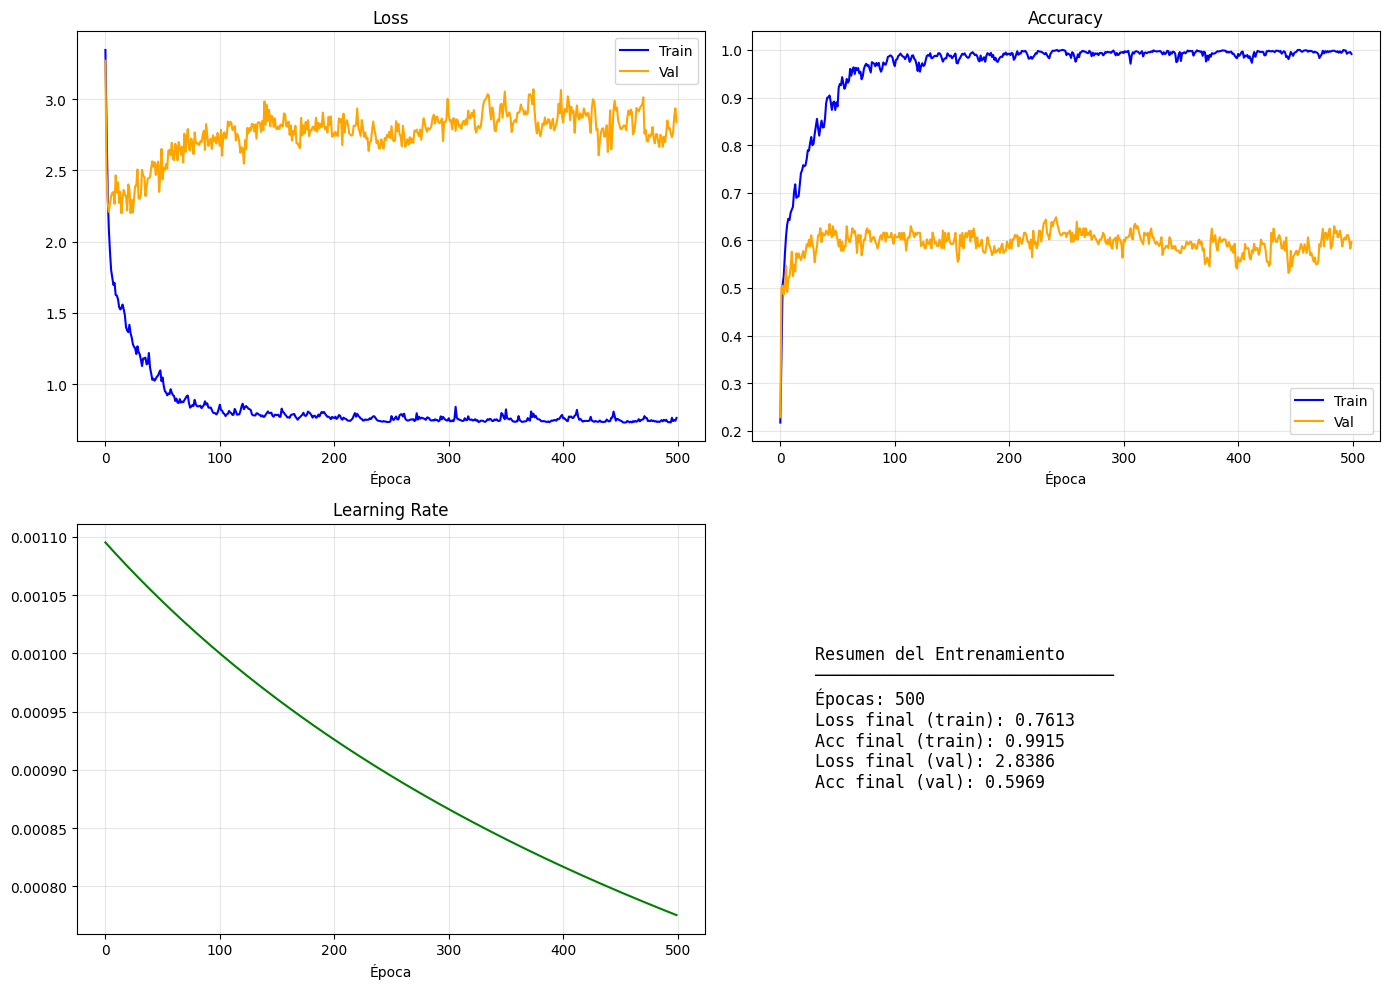

Gráficas guardadas en checkpoints/training_curves.png


In [13]:
# Intentar graficar con matplotlib si está disponible
try:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train', color='blue')
    if history.get('val_loss'):
        axes[0, 0].plot(history['val_loss'], label='Val', color='orange')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history['train_accuracy'], label='Train', color='blue')
    if history.get('val_accuracy'):
        axes[0, 1].plot(history['val_accuracy'], label='Val', color='orange')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 0].plot(history['learning_rates'], color='green')
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Resumen final
    axes[1, 1].axis('off')
    summary_text = (
        f"Resumen del Entrenamiento\n"
        f"{'─'*30}\n"
        f"Épocas: {len(history['train_loss'])}\n"
        f"Loss final (train): {history['train_loss'][-1]:.4f}\n"
        f"Acc final (train): {history['train_accuracy'][-1]:.4f}\n"
    )
    if history.get('val_loss'):
        summary_text += (
            f"Loss final (val): {history['val_loss'][-1]:.4f}\n"
            f"Acc final (val): {history['val_accuracy'][-1]:.4f}\n"
        )
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
                    verticalalignment='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.savefig(os.path.join(project_root, 'checkpoints', 'training_curves.png'), dpi=150)
    plt.show()
    print("Gráficas guardadas en checkpoints/training_curves.png")
    
except ImportError:
    print("matplotlib no disponible. Usa las gráficas de texto anteriores.")
    print("Instalar con: pip install matplotlib")